# Monte Carlo Integration

This notebook is based on Lecture 9 of the Computational Finance course https://www.youtube.com/playlist?list=PL6zzGYGhbWrPaI-op1UfNl0uDglxdkaOB

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

## Monte Carlo integration of a deterministic function


Let us calculate the integral of an exponential function $\int_0^1 e^x dx$ using two methods:

(1) *Naive method*:  
    - create a rectangular domain spanning $[a,b]=[0,1]$ on the $x$-axis and $[c,d]=[1,3]$ on the $y$-axis  
    - draw $N$ random numbers along both the axes  
    - calculate the number of points $p$ satisfying $e^{x_i}>y_i$  
    - the estimated integral is then $p/N$

(2) *Expectation approach*:  
    - note that $\int_0^1 e^x dx = \langle e^x\rangle_{\mathcal{U}[0,1]}$ where $\langle\cdot\rangle$ denotes expectation calculation per $\mathcal{U}[0,1]$, the uniform distribution between 0 and 1  
    - to estimate the integral, we draw $N$ uniform random numbers between 0 and 1  
    - for each random number $x_i$, calculate $e^{x_i}$  
    - the estimated integral is the mean $\sum_{i=1}^N e^{x_i}/N$


Integral estimate using naive approach with 1000 samples is 1.734
Integral estimate using expectation approach with 1000 samples is 1.7079435311728903


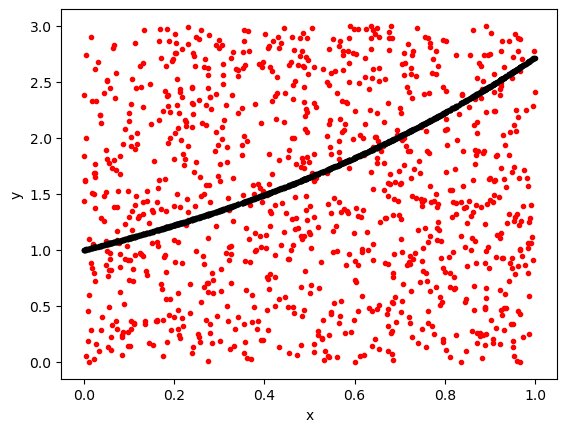

In [26]:
# --- Method 1: naive approach ---
def naive(function, a, b, c, d, nSamples):    
    x = np.random.uniform(a,b,nSamples)
    y = np.random.uniform(c,d,nSamples)
    
    p = function(x) > y
    p = np.mean(p)
    
    integral = p * (b-a) * (d-c) 
    
    plt.figure()
    plt.plot(x,y,'.r')
    plt.plot(x,function(x),'.k')
    plt.xlabel('x')
    plt.ylabel('y')
    return integral

f = lambda x: np.exp(x)
a = 0
b = 1
c = 0
d = 3
nSamples = 1000
estimate_naive = naive(f, a, b, c, d, nSamples)
print("Integral estimate using naive approach with", nSamples, "samples is", estimate_naive)

# --- Method 2: expectation approach ---
def expectation(function, a, b, nSamples): 
    x = np.random.uniform(a, b, nSamples)  
    integral = (b-a) * np.mean(function(x))
    return integral

estimate_exp = expectation(f, a, b, nSamples)
print("Integral estimate using expectation approach with", nSamples, "samples is", estimate_exp)

## Monte Carlo integration of a deterministic function over a Wiener process

Consider the integral $\int_0^1 g(t)dW(t)$ where $g(t)=t^2$. The integral has vanishing mean. The variance is thus
$$\mathrm{Var}\left[\int_0^1 t^2dW(t)\right] = \mathrm{E}\left[\left(\int_0^1 t^2dW(t)\right)^2\right] = \mathrm{E}\left[\int_0^1 t^4dt\right] = 0.2$$
The penultimate step follows from Ito isometry. We will now calculate the variance of the integral using Monte Carlo integration and compare it with the analytical value.

Mean is -1.4210854715202004e-18 and variance is 0.19039183227190937
Theoretical variance: 0.2


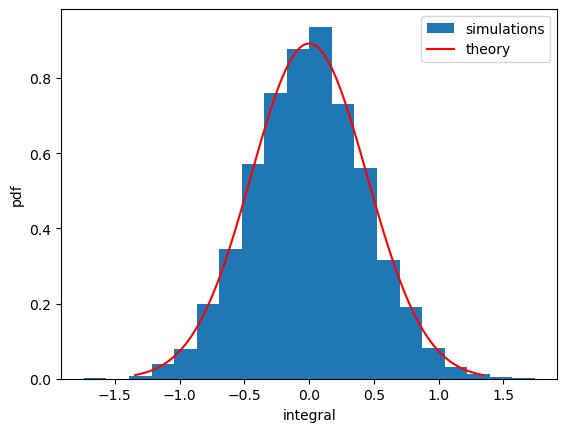

In [18]:
def integrate(function, a, b, nSamples, nSteps):
    rand = np.random.normal(0, 1, ((nSamples, nSteps)))
    w = np.zeros((nSamples, nSteps+1))
    integral = np.zeros((nSamples, nSteps+1))
    t = np.zeros(nSteps+1)
    t[0] = a
    dt = (b-a) / nSteps
    for i in range(nSteps):
        rand = (rand - np.mean(rand[:,i])) / np.std(rand[:,1])
        w[:,i+1] = w[:,i] + np.sqrt(dt) * rand[:,i]
        integral[:,i+1] = integral[:,i] + function(t[i]) * np.sqrt(dt) * rand[:,i]
        t[i+1] = t[i] + dt
    print("Mean is", np.mean(integral[:,-1]), "and variance is", np.var(integral[:,-1]))
    return integral

integral = integrate(lambda x: x**2, 0, 1, 5000, 1000)
plt.hist(integral[:,-1],bins=20,density=1,label='simulations')
plt.xlabel('Integral')
plt.ylabel('PDF')

# theory
mu = 0
variance = 0.2
sigma = np.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma),'r',label='theory')
print("Theoretical variance:",0.2)

plt.legend()

## Monte Carlo integration of a stochastic function over a Wiener process

Consider the integral $G(2)=\int_0^2 W(s)dW(s)$. Applying Ito's rule to $f=W^2$, we get,
\begin{equation}
df = 2WdW + dt.
\end{equation}
This gives $G(2) = (W^2(2)-2)/2$. Note that since $W$ is normally distributed, $W^2$ is $\chi^2$ distributed. The following properties are satisfied by $G(2)$:  
(1) $E[G(2)] = 0$  
(2) $\mathrm{Var}[G(2)] = 2$

Mean is -0.005421931895846272 and variance is 1.9719339391961286
Theoretical variance: 2


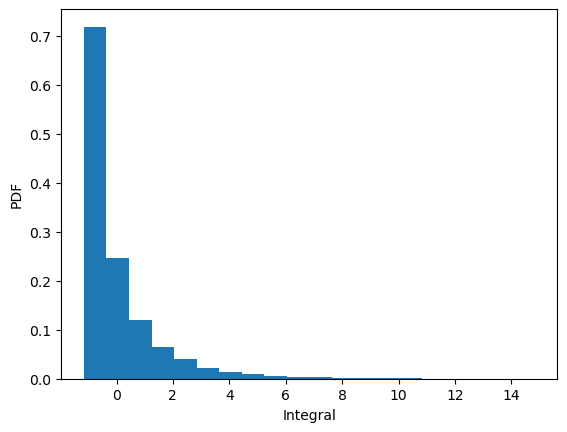

In [20]:
def integrate(a, b, nSamples, nSteps):
    rand = np.random.normal(0, 1, ((nSamples, nSteps)))
    w = np.zeros((nSamples, nSteps+1))
    integral = np.zeros((nSamples, nSteps+1))
    t = np.zeros(nSteps+1)
    t[0] = a
    dt = (b-a) / nSteps
    for i in range(nSteps):
        rand = (rand - np.mean(rand[:,i])) / np.std(rand[:,1])
        w[:,i+1] = w[:,i] + np.sqrt(dt) * rand[:,i]
        integral[:,i+1] = integral[:,i] + w[:,i] * np.sqrt(dt) * rand[:,i]
        t[i+1] = t[i] + dt
    print("Mean is", np.mean(integral[:,-1]), "and variance is", np.var(integral[:,-1]))
    return integral

integral = integrate(0, 2, 5000, 1000)
plt.hist(integral[:,-1],bins=20,density=1)
plt.xlabel('Integral')
plt.ylabel('PDF')

# theory
print("Theoretical variance:",2)

## Euler and Milstein discretization

Euler discretization of geometric Brownian motion reads
\begin{equation}
S(t_{i+1}) = S(t_i) + \mu S(t_i)\Delta t + \sigma S(t_i)\sqrt{\Delta t}z_i.
\end{equation}

Milstein discretization includes the next higher order term of the Taylor expansion and reads
\begin{equation}
S(t_{i+1}) = S(t_i) + \mu S(t_i)\Delta t + \sigma S(t_i)\sqrt{\Delta t}z_i + \frac{1}{2}\sigma^2S(t_i)\Delta t(z_i^2-1)
\end{equation}
where $z_i\sim\mathcal{N}(0,1)$ is a random sample drawn from a standard normal distribution. 

We compare the resulting asset price trajectory with that obtained from the solution of GBM, viz.,
\begin{equation}
S(t_i+\Delta t) = S(t_i) \exp\left\{\left(r-\frac{1}{2}\sigma^2\right)\Delta t + \sigma[W(t_i+\Delta t)-W(t_i)]\right\}.
\end{equation}
To quantify, we compute the errors that help estimate strong and weak convergence
\begin{align*}
\epsilon^\text{strong} &= E\left[|S_\text{Euler}-S_\text{GBM}|\right] \\
\epsilon^\text{weak} &= |E[S_\text{Milstein}]-E[S_\text{GBM}]|
\end{align*}

Text(0, 0.5, 'Error $\\varepsilon^\\mathrm{strong}$')

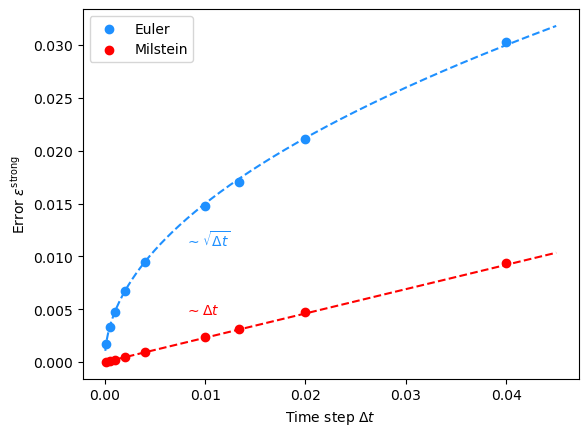

In [58]:
def paths_euler(S0, mu, sigma, T, nSteps, nSamples):
    rand = np.random.normal(0, 1, ((nSamples, nSteps)))
    S_mc = np.zeros((nSamples, nSteps+1))
    S_gbm = np.zeros((nSamples, nSteps+1))
    S_mc[:,0] = S0
    S_gbm[:,0] = S0
    dt = T / nSteps
    for i in range(nSteps):
        rand[:,i] = (rand[:,i] - np.mean(rand[:,i])) / np.std(rand[:,i])
        S_mc[:,i+1] = S_mc[:,i] + mu * S_mc[:,i] * dt + sigma * S_mc[:,i] * np.sqrt(dt) * rand[:,i]
        S_gbm[:,i+1] = S_gbm[:,i] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * rand[:,i])
    return {"S_mc":S_mc, "S_gbm":S_gbm}

def paths_milstein(S0, mu, sigma, T, nSteps, nSamples):
    rand = np.random.normal(0, 1, ((nSamples, nSteps)))
    S_mc = np.zeros((nSamples, nSteps+1))
    S_gbm = np.zeros((nSamples, nSteps+1))
    S_mc[:,0] = S0
    S_gbm[:,0] = S0
    dt = T / nSteps
    for i in range(nSteps):
        rand[:,i] = (rand[:,i] - np.mean(rand[:,i])) / np.std(rand[:,i])
        S_mc[:,i+1] = S_mc[:,i] + mu * S_mc[:,i] * dt + sigma * S_mc[:,i] * np.sqrt(dt) * rand[:,i] + 0.5 * sigma**2 * S_mc[:,i] * dt * (rand[:,i]**2 - 1)
        S_gbm[:,i+1] = S_gbm[:,i] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * rand[:,i])
    return {"S_mc":S_mc, "S_gbm":S_gbm}

def strong_convergence(S_mc, S_gbm):
    S_mc = S_mc[:,-1]
    S_gbm = S_gbm[:,-1]
    err = np.mean(np.abs(S_mc - S_gbm))
    return err

def weak_convergence(S_mc, S_gbm):
    S_mc = S_mc[:,-1]
    S_gbm = S_gbm[:,-1]
    err = np.abs(np.mean(S_mc)-np.mean(S_gbm))
    return err

# compare Euler and Milstein discretization
T = 1
steps = np.array([25,50,75,100,250,500,1000,2000,8000])
dts = T / steps
err_strong_euler = np.zeros(len(steps))
err_weak_euler = np.zeros(len(steps))
err_strong_milstein = np.zeros(len(steps))
err_weak_milstein = np.zeros(len(steps))
for i, nSteps in enumerate(steps):
    p = paths_euler(100, 0.05, 0.05, T, nSteps, 5000)
    S_mc = p["S_mc"]
    S_gbm = p["S_gbm"]
    err_strong_euler[i] = strong_convergence(S_mc,S_gbm)
    err_weak_euler[i] = weak_convergence(S_mc,S_gbm)

    p = paths_milstein(100, 0.05, 0.05, T, nSteps, 5000)
    S_mc = p["S_mc"]
    S_gbm = p["S_gbm"]
    err_strong_milstein[i] = strong_convergence(S_mc,S_gbm)
    err_weak_milstein[i] = weak_convergence(S_mc,S_gbm)


plt.scatter(dts,err_strong_euler,c='dodgerblue',label='Euler')
plt.scatter(dts,err_strong_milstein,c='red',label='Milstein')
xs = np.arange(5e-5,0.045,1e-5)
plt.plot(xs,0.15*np.sqrt(xs),'--',c='dodgerblue')
plt.plot(xs,0.23*xs,'--',c='red')
plt.text(8e-3,0.011,r'$\sim \sqrt{\Delta t}$',color='dodgerblue')
plt.text(8e-3,0.0045,r'$\sim \Delta t$',color='red')
plt.legend()
plt.xlabel(r'Time step $\Delta t$')
plt.ylabel(r'Error $\varepsilon^\mathrm{strong}$')